In [1]:
using Pkg
pkg"activate ."
# pkg"add MLDatasets MLDataUtils LinearAlgebra Images StatsBase https://github.com/sadit/KCenters.jl https://github.com/sadit/SimilaritySearch.jl"
using MLDatasets, MLDataUtils, LinearAlgebra, Images, StatsBase, KCenters, SimilaritySearch

Activating environment at `~/Research/KCenters.jl/tutorials/Project.toml`


┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/MLDatasets/9CUQK.ji for MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/sadit/.julia/compiled/v1.2/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1240


(method = "kcenters m=100", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l1_distance, acc = 0.795)

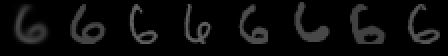

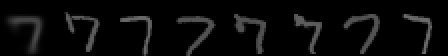

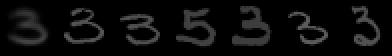

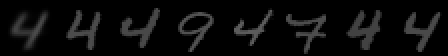

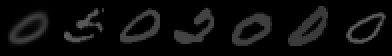

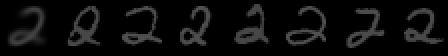

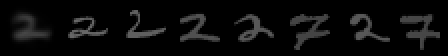

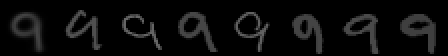

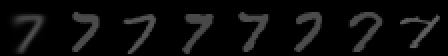

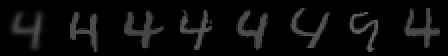

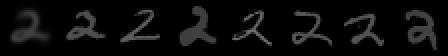

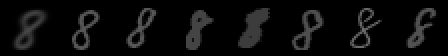

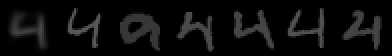

(method = "kcenters m=100", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l2_distance, acc = 0.8615)

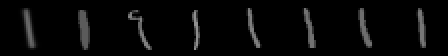

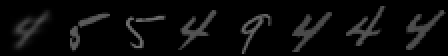

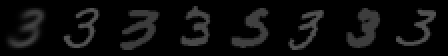

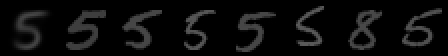

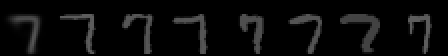

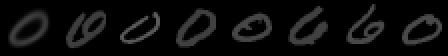

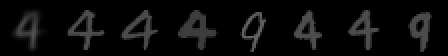

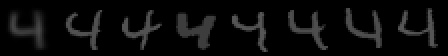

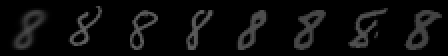

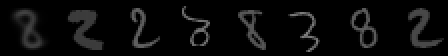

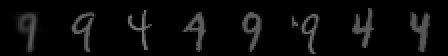

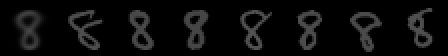

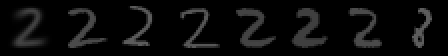

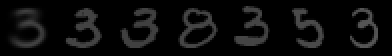

(method = "kcenters m=100", kernel = KCenters.relu_kernel, dist = SimilaritySearch.cosine_distance, acc = 0.8612)

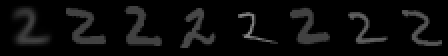

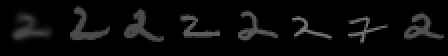

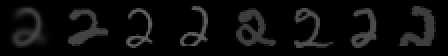

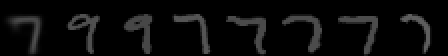

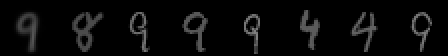

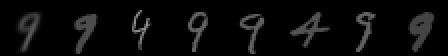

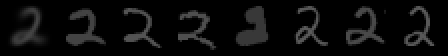

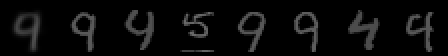

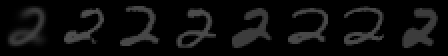

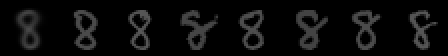

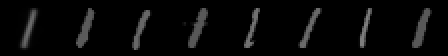

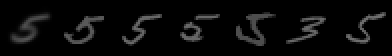

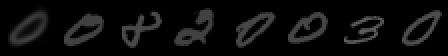

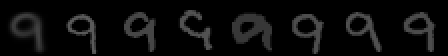

(method = "kcenters by label", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l1_distance, acc = 0.6812)

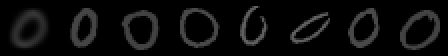

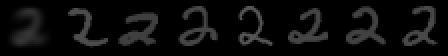

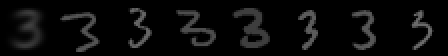

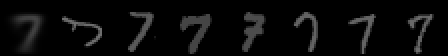

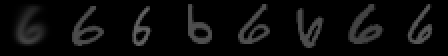

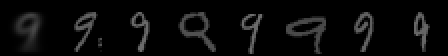

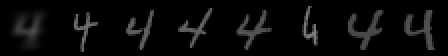

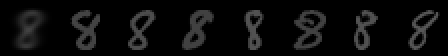

(method = "kcenters by label", kernel = KCenters.relu_kernel, dist = SimilaritySearch.l2_distance, acc = 0.7874)

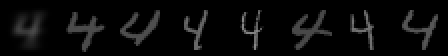

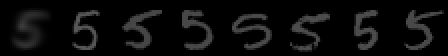

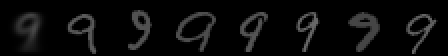

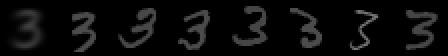

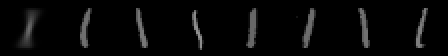

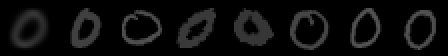

(method = "kcenters by label", kernel = KCenters.relu_kernel, dist = SimilaritySearch.cosine_distance, acc = 0.7562)

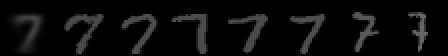

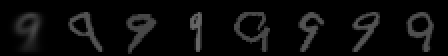

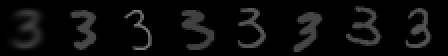

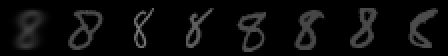

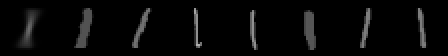

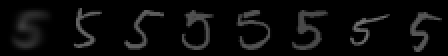

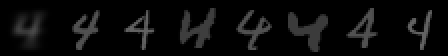

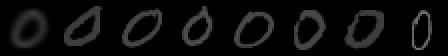

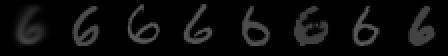

In [21]:
function normalize_vector(v)
    normalize(v)
    # Float32.(v)
end

# visualization helpers
f(x) = reshape(x, (28, 28))'
function display_examples(P, train_X, s=7)
    for c in unique(rand(1:length(P.nc.centers), s*2))
        sm = unique(rand(P.index.lists[c], s))
        xx = hcat(f(P.nc.centers[c]), f.(train_X[sm])...)
        (Gray.(xx * 3)) |> display
    end
end


"""
    load_data()

Loads the MNIST benchmark and converts the dataset to individual vectors; labels are also encoded as integers
"""
function load_data()
    train_X, train_y = MNIST.traindata()
    test_X, test_y = MNIST.testdata()
    n1 = size(train_X)[end]
    n2 = size(test_X)[end]
    le = labelenc(train_y)
    
    # KCenters work with collections of vectors more than concatenation of them
    X1 = [normalize_vector(c) for c in eachcol(reshape(train_X, (28 * 28, n1)))]
    X2 = [normalize_vector(c) for c in eachcol(reshape(test_X, (28 * 28, n2)))]
    X1, label2ind.(train_y, le), X2, label2ind.(test_y, le)
end

"""
    run(dist, C, train_X, train_y, test_X, test_y)

Creates and runs a nearest centroid classifier using the specified kernel
"""
function run(kernel, C, train_X, train_y, test_X, test_y)
    I = fit(DeloneInvIndex, train_X, C)
    nc = fit(NearestCentroid, I, train_y)
    ypred = predict(nc, kernel, test_X)
    (accuracy=mean(ypred .== test_y), nc=nc, index=I)
end

"""
    main()

Compares a number of kcenter inputs and configurations for nearest centroids over MNIST dataset
"""
function main()
    train_X, train_y, test_X, test_y = load_data()
    O = []
    P = nothing
    for dist_ = [l1_distance, l2_distance, cosine_distance]
        C = kcenters(dist_, train_X, 100, mean, initial=:fft, recall=1.0, verbose=false, maxiters=10)
        #for kernel_ in [gaussian_kernel, laplacian_kernel, sigmoid_kernel, relu_kernel]
        for kernel_ in [relu_kernel]
            P = run(kernel_(dist_), C, train_X, train_y, test_X, test_y)
            push!(O, (method="kcenters m=100", kernel=kernel_, dist=dist_, acc=P.accuracy))
            display(O[end])
            display_examples(P, train_X)
        end
    end

    for dist_ = [l1_distance, l2_distance, cosine_distance]
        C = kcenters(dist_, train_X, train_y, mean)
        for kernel_ in [relu_kernel]
            P = run(kernel_(dist_), C, train_X, train_y, test_X, test_y)
            push!(O, (method="kcenters by label", kernel=kernel_, dist=dist_, acc=P.accuracy))
            display(O[end])
            display_examples(P, train_X)
        end
    end
    
    
    #display("text/markdown", join(output, "\n"))
end


main()
